# Canola weekly

In [1]:
import pandas as pd
import numpy as np

from datetime import datetime

import glob
import xarray as xr

import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm

from statsmodels.tsa.holtwinters import SimpleExpSmoothing, ExponentialSmoothing 

from sklearn.linear_model import LinearRegression

from sktime.transformations.series.detrend import Detrender
from sktime.forecasting.trend import PolynomialTrendForecaster
from sktime.utils.plotting import plot_series

import seaborn as sns

In [2]:
#read dataframe 
canola_2 = df = pd.read_csv('../data/rm-yields-data.csv', header=0, index_col=0, parse_dates=True)
canola_small = canola_2.iloc[:, [0, 2]].copy()

#cut of first 33 observations (NAs)
canola_small.drop(canola_small.index[:33], inplace=True)

#filter out every observation that contains NAs
canola_filtered = canola_small.groupby('RM').filter(lambda group: not group['Canola'].isnull().any())

# how may districts? 148
num_districts = canola_filtered.groupby('RM').ngroups

#extract only the first district 
canola_dist1 = canola_filtered[canola_filtered['RM'] == 1]

In [3]:
# Group by 'RM' and check if 'Canola' has any missing values in each group
districts_with_full_data = canola_filtered.groupby('RM')['Canola'].apply(lambda group: not group.isnull().any())

# Extract the list of districts with full data
districts_with_full_data_list = districts_with_full_data[districts_with_full_data].index.tolist()

# Print or use the list as needed
print("Districts with full data:", districts_with_full_data_list)
print(len(districts_with_full_data_list))

Districts with full data: [1, 2, 3, 32, 61, 63, 64, 65, 92, 93, 95, 122, 123, 125, 126, 127, 152, 153, 154, 155, 156, 157, 181, 183, 184, 185, 186, 211, 213, 214, 217, 221, 222, 241, 243, 244, 245, 246, 250, 251, 252, 254, 271, 273, 276, 277, 278, 280, 281, 283, 284, 304, 305, 307, 308, 309, 310, 312, 314, 315, 316, 331, 333, 334, 335, 336, 337, 338, 339, 340, 341, 342, 343, 344, 345, 346, 347, 349, 350, 351, 352, 366, 367, 368, 369, 370, 371, 372, 373, 377, 378, 380, 381, 382, 394, 395, 398, 399, 400, 401, 402, 403, 404, 405, 406, 408, 409, 410, 411, 426, 427, 428, 429, 430, 431, 435, 436, 437, 438, 439, 440, 442, 456, 457, 458, 459, 460, 461, 463, 464, 466, 467, 468, 471, 472, 486, 487, 488, 490, 491, 493, 494, 497, 499, 501, 502, 588, 622]
148


In [4]:
cop_all = xr.open_mfdataset(paths='../data/raw_data/*.nc', combine='by_coords')

cop_all_centralized = cop_all.mean(dim=['latitude', 'longitude'])

<YearEnd: month=12>
ADF Statistic: -6.57329056709387
p-value: 7.838097223650602e-09


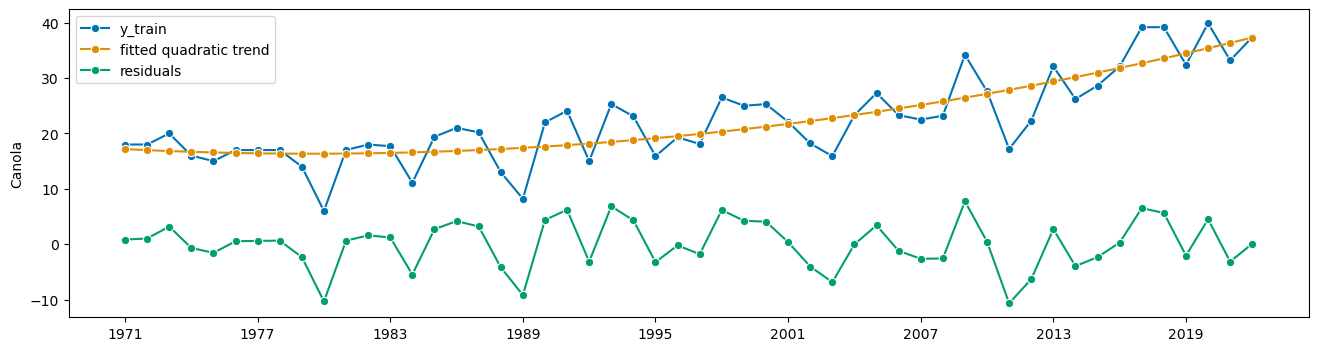

In [5]:
canola_dist1.index = canola_dist1.index.to_period('A')

#change frequency 
frequency = canola_dist1.index.freq

print(frequency)

# linear detrending
forecaster = PolynomialTrendForecaster(degree=2)
transformer = Detrender(forecaster=forecaster)
yt = transformer.fit_transform(canola_dist1['Canola'])


forecaster = PolynomialTrendForecaster(degree=2)
fh_ins = -np.arange(len(canola_dist1['Canola'])) 
y_pred = forecaster.fit(canola_dist1['Canola']).predict(fh=fh_ins)

plot_series(canola_dist1['Canola'], y_pred, yt, labels=["y_train", "fitted quadratic trend", "residuals"]);

residuals = yt

#ADF 
result = adfuller(residuals)
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')

In [6]:
column_to_append = yt.tolist()

dist1_df = cop_all_centralized.to_dataframe()

years = dist1_df.index.year
dist1_df['Canola_detrend'] = [column_to_append[year - 1971] for year in years]

dist1_df.tail()

,t2m,tp,Canola_detrend
time,,,
2022-10-31 19:00:00,285.548615,0.000000e+00,0.076926
2022-10-31 20:00:00,286.406525,5.997717e-07,0.076926
2022-10-31 21:00:00,286.554352,5.997717e-07,0.076926
2022-10-31 22:00:00,286.267975,5.997717e-07,0.076926
2022-10-31 23:00:00,285.108826,5.997717e-07,0.076926


In [7]:
column_to_append = yt.tolist()

canola_dist1.loc[:, 'Canola_detrend'] = column_to_append

canola_dist1.drop(canola_dist1.columns[:2], axis=1, inplace=True)

#canola_dist1

C:\Users\maris\AppData\Local\Temp\ipykernel_42720\3757530005.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  canola_dist1.loc[:, 'Canola_detrend'] = column_to_append
C:\Users\maris\AppData\Local\Temp\ipykernel_42720\3757530005.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  canola_dist1.drop(canola_dist1.columns[:2], axis=1, inplace=True)


In [11]:
#resamle weekly 
weekly_avg_temperatures = dist1_df.resample('W-Mon').mean()

weekly_sum_rain = dist1_df.resample('W-Mon').sum()

#drop nan
weekly_avg_temperatures = weekly_avg_temperatures.dropna()
weekly_sum_rain = weekly_sum_rain.dropna()

# Initialize the new column with zeros
weekly_avg_temperatures['week_number'] = 0 
weekly_sum_rain['week_number'] = 0 

# Initialize the new column with zeros

# Create a new column with number of the week 
for timestamp in weekly_avg_temperatures.index:
    
    # Convert timestamp to year and ISO week number
    iso_year, iso_week, _ = timestamp.isocalendar()
    
    # Update the 'week_number' column with the ISO week number
    weekly_avg_temperatures.at[timestamp, 'week_number'] = iso_week

    
for timestamp in weekly_sum_rain.index:
    # Convert timestamp to year and ISO week number
    iso_year, iso_week, _ = timestamp.isocalendar()
    
    # Update the 'week_number' column with the ISO week number
    weekly_sum_rain.at[timestamp, 'week_number'] = iso_week
    

#print(weekly_sum_rain)

min_value = weekly_avg_temperatures['week_number'].min()
max_value = weekly_avg_temperatures['week_number'].max()

#start from week 15 since week 14 is not complete for all years, same for week 45

for week in range(15,45):
    
    week_data_temp = weekly_avg_temperatures[weekly_avg_temperatures['week_number'] == week]
    column_to_append = week_data_temp['t2m'].tolist()
    canola_dist1.loc[:, f'avg_temp_in_week_{week}'] = column_to_append
    
    week_data_rain = weekly_sum_rain[weekly_sum_rain['week_number'] == week]
    column_to_append = week_data_rain['tp'].tolist()
    canola_dist1.loc[:, f'total_rain_week_{week}'] = column_to_append

print(canola_dist1.columns)


Index(['Canola_detrend', 'avg_temp_in_week_15', 'total_rain_week_15',
       'avg_temp_in_week_16', 'total_rain_week_16', 'avg_temp_in_week_17',
       'total_rain_week_17', 'avg_temp_in_week_18', 'total_rain_week_18',
       'avg_temp_in_week_19', 'total_rain_week_19', 'avg_temp_in_week_20',
       'total_rain_week_20', 'avg_temp_in_week_21', 'total_rain_week_21',
       'avg_temp_in_week_22', 'total_rain_week_22', 'avg_temp_in_week_23',
       'total_rain_week_23', 'avg_temp_in_week_24', 'total_rain_week_24',
       'avg_temp_in_week_25', 'total_rain_week_25', 'avg_temp_in_week_26',
       'total_rain_week_26', 'avg_temp_in_week_27', 'total_rain_week_27',
       'avg_temp_in_week_28', 'total_rain_week_28', 'avg_temp_in_week_29',
       'total_rain_week_29', 'avg_temp_in_week_30', 'total_rain_week_30',
       'avg_temp_in_week_31', 'total_rain_week_31', 'avg_temp_in_week_32',
       'total_rain_week_32', 'avg_temp_in_week_33', 'total_rain_week_33',
       'avg_temp_in_week_34', 'total